# 1st project
Author: *Zigfrid Zvezdin*  
Tutor: *Dmitri Kamzolov*  
Special thanks to: *Meruza Kubentaeva*

## Introduction
### Goals
At this project we were supposed to implement algorithms from [Primal-dual accelerated gradient methods with small-dimensional relaxation oracle](https://arxiv.org/abs/1809.05895) paper and apply it to [Anaheim transport network](https://github.com/bstabler/TransportationNetworks) with Beckmann model. However, due to the nature of the algorithm we were not able to do this, so we finished by developing another algorithm.
### Work on the project
The idea was to take [Meruza's project](https://github.com/MeruzaKub/TransportNet) and add an implementation of the Universal Accelerated Gradient Method with Small-Dimensional Relaxation (UAGMsDR).  
During the work on the project, some technical issues were encountered:
1. **Problem**: difficulties installing the essential for the project [Graph tool library](https://graph-tool.skewed.de/). **Solution**: creating a Docker image based on [Graph tool Docker image](https://git.skewed.de/count0/graph-tool/wikis/installation-instructions).
2. **Problem**: a newer version of Graph tool caused non-compilation of the code in the repo. The first found fix of the problem actually did not fix the problem. **Solution**: Compare the versions of the library and find how some specific functions changed.

## Algorithm
Due to ... **(Дима, напиши, плиз)**, we couldn't apply the algorithms from the paper in our project. Fortuantely, we found an extremly well numerically converging algorithm (refer to the paper for the notations):

**Input**: Accuracy $\epsilon$, constants $\beta$ and $h$  
**Output**: $x^k$
1. Set $k=0, A_0=0, x^0=v^0, \psi_0(x)=V(x,x^0)$
2. **for $k \geq 0$ do**
3. $y^k = v^k + \beta_k(x^k-v^k)$
4. $x^{k+1} = y^k - h_{k+1}\nabla f(y^k)$. Find $a_{k+1}$ from equation $f(y^k) - \frac{a_{k+1}^2}{2(A_k+a_{k+1})}||\nabla f(y^k)||^2+\frac{\epsilon a_{k+1}}{2(A_k+a_{k+1})} = f(x^{k+1})$
5. Set $A_{k+1} = A_k + a_{k+1}$.
6. Set $\psi_{k+1} = \psi_k(x) + a_{k+1}(f(y^k)+(\nabla(y^k),x-y^k))$.
7. $v^{k+1} = \arg \min_{x\in E}\psi_{k+1}(x)$
8. $k = k + 1$
9. end for

Compared to UAGMsDR, we replaced argmins with constant values. Also, in our case $E = E^{*}$.

# Structure (потом удалю)
1. Introduction - what we were supposed to do and what we did (and why). Also talk about some technical issues (Docker, Graph_tool installation, Graph_tool version).
2. Our algorithm (because linear search was out of the range so we fixed h and beta).
3. Experiments (different beta and h). Compare with Frank-Wolfe (the best know algorithm) (or with triangles) - plot the same lines on one plot. 2 primals, 2 duals, 2 gaps.
    h, beta = 0, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001 for 100 iterations
    for 4 best we try 1000 iterations
    compare with 10, 100, 1000 iterations with Frank-Wolfe (or maybe leave one) (compare 2&2&2)
4. Conclusion (better numerical convergance than Frank-Wolfe).
5. Clean files, Github and * Publish Docker image. Fix verbose.

## Code

### Imports

In [1]:
import pandas as pd
import numpy as np
import data_handler as dh
import model as md
import time
import matplotlib.pyplot as plt
from matplotlib import rc
import pickle

### Data Initializing for Beckmann model

In [2]:
net_name = 'Anaheim_net.tntp'
trips_name = 'Anaheim_trips.tntp'

handler = dh.DataHandler()
graph_data = handler.GetGraphData(net_name, columns_order = np.array([0, 1, 2, 4]))
graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)

model = md.Model(graph_data, graph_correspondences, 
                    total_od_flow, mu = 0.25, rho = 0.15)
model.mu = 0.25

graph_data['graph_table'].head()

,Init node,Term node,Capacity,Free Flow Time
0,1,117,9000.0,1.090459
1,2,87,9000.0,1.090459
2,3,74,9000.0,1.090459
3,4,233,9000.0,1.090459
4,5,165,9000.0,1.090459


## mu = 0 - Stable Dynamics (удалю)

In [3]:
# net_name = 'Anaheim_net.tntp'
# trips_name = 'Anaheim_trips.tntp'

# handler = dh.DataHandler()
# graph_data = handler.GetGraphData(net_name, columns_order = np.array([0, 1, 2, 4]))
# graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)

# graph_data['graph_table']['Capacity'] = 2.5 * graph_data['graph_table']['Capacity']

# model = md.Model(graph_data, graph_correspondences, 
#                  total_od_flow, mu = 0, rho = 0.15)

# graph_data['graph_table'].head()

In [4]:
# max_iter = 10

# eps_abs = -1 # doesn't matter

# # print('eps_abs =', eps_abs)
# solver_kwargs = {'max_iter': max_iter}
# tic = time.time()
# result = model.find_equilibrium(solver_name = 'uagmsdr', solver_kwargs = solver_kwargs, verbose = False) #verbose = False
# toc = time.time()
# print('Elapsed time: {:.0f} sec'.format(toc - tic))

# print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['Free Flow Time']))
# print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['Capacity']) - 1, end = '\n\n')

# result['eps_abs'] = eps_abs
# #with open('anaheim_result_' + 'ustf' + '_#' + str(i) + '_max_iter_' + str(max_iter) + 
# #          '_Beckman.pickle', 'wb') as f:
# #    pickle.dump(result, f)
# #these results in 'results' folder

### Experiments
We will look at the convergence with different ranges of $\beta$, $h$ and number of iterations $max\_iter$.

Define ranges 

In [36]:
beta_range = [0., 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
h_range = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
max_iter = 100

Define utils

In [69]:
def read_experiment(beta, h, max_iter, folder='results'):
    with open(f'{folder}/uagmsdr_beta={beta}_h={h}_max_iter={max_iter}.pickle', 'rb') as f:
        result = pickle.load(f)
        return result
def read_experiments(beta_range, h_range, max_iter, folder='results'):
    results = {}
    for beta in beta_range:
        for h in h_range:
            results[(beta,h)] = read_experiment(beta, h, max_iter, folder)
    return results
def parse_results(results):
    flows = {}
    times = {}
    iter_nums = {}
    primal_vals = {}
    dual_vals = {}
    dual_gaps = {}
    for key in results:
        flows[key]=results[key]['flows']
        times[key]=results[key]['times']
        iter_nums[key]=results[key]['iter_num']
        primal_vals[key]=results[key]['primal_func_history']
        dual_vals[key]=results[key]['dual_func_history']
    return flows, times, iter_nums, primal_vals, dual_vals

Keep track of experminets in dictionaries

In [37]:
flows = {}
times = {}
iter_nums = {}
primal_vals = {}
dual_vals = {}
dual_gaps = {}
results = {}

Run experiments

In [38]:
for beta in beta_range:
    for h in h_range:
        print(f'beta={beta},h={h}')
        solver_kwargs = {'beta': beta,
                         'h': h,
                         'max_iter': max_iter}
        tic = time.time()
        result = model.find_equilibrium(solver_name = 'uagmsdr', solver_kwargs = solver_kwargs, verbose = False) #verbose = False
        toc = time.time()
        print('Elapsed time: {:.0f} sec'.format(toc - tic))

        print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['Free Flow Time']))
        print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['Capacity']) - 1, end = '\n\n')

        flows[(beta,h)]=result['flows']
        times[(beta,h)]=result['times']
        iter_nums[(beta,h)]=result['iter_num']
        primal_vals[(beta,h)]=result['primal_func_history']
        dual_vals[(beta,h)]=result['dual_func_history']
        results[(beta,h)]=result

        with open(f'results/uagmsdr_beta={beta}_h={h}_max_iter={max_iter}.pickle', 'wb') as f:
            pickle.dump(result, f)

beta=0.0,h=0.01
Primal_func_value = 1.26452e+06
Duality_gap / Duality_gap_init = 0.000339273
Phi_big_oracle elapsed time: 0 sec
Primal_func_value = 1.21961e+06
Duality_gap / Duality_gap_init = 4.66461e-05
Phi_big_oracle elapsed time: 1 sec
Primal_func_value = 1.21425e+06
Duality_gap / Duality_gap_init = 2.66706e-05
Phi_big_oracle elapsed time: 1 sec
Primal_func_value = 1.2112e+06
Duality_gap / Duality_gap_init = 1.62808e-05
Phi_big_oracle elapsed time: 1 sec
Primal_func_value = 1.21003e+06
Duality_gap / Duality_gap_init = 1.50536e-05
Phi_big_oracle elapsed time: 2 sec
Primal_func_value = 1.20859e+06
Duality_gap / Duality_gap_init = 7.73921e-06
Phi_big_oracle elapsed time: 2 sec
Primal_func_value = 1.20798e+06
Duality_gap / Duality_gap_init = 7.49987e-06
Phi_big_oracle elapsed time: 2 sec
Primal_func_value = 1.20747e+06
Duality_gap / Duality_gap_init = 6.07288e-06
Phi_big_oracle elapsed time: 2 sec
Primal_func_value = 1.20722e+06
Duality_gap / Duality_gap_init = 4.79756e-06
Phi_big_orac

Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 1.79185e-07
Phi_big_oracle elapsed time: 21 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 2.18667e-07
Phi_big_oracle elapsed time: 21 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 2.12653e-07
Phi_big_oracle elapsed time: 21 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 2.43397e-07
Phi_big_oracle elapsed time: 21 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 2.07699e-07
Phi_big_oracle elapsed time: 22 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 9.84037e-08
Phi_big_oracle elapsed time: 22 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 2.36999e-07
Phi_big_oracle elapsed time: 22 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 1.70335e-07
Phi_big_oracle elapsed time: 23 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 2.08165e-07
Phi_big_oracle elap

Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 6.03155e-06
Phi_big_oracle elapsed time: 13 sec
Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 3.90033e-06
Phi_big_oracle elapsed time: 13 sec
Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 7.57238e-06
Phi_big_oracle elapsed time: 14 sec
Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 7.36626e-06
Phi_big_oracle elapsed time: 14 sec
Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 5.98665e-06
Phi_big_oracle elapsed time: 14 sec
Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 5.25674e-06
Phi_big_oracle elapsed time: 14 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 4.74074e-06
Phi_big_oracle elapsed time: 15 sec
Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 7.61831e-06
Phi_big_oracle elapsed time: 15 sec
Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 6.88825e-06
Phi_big_oracle elap

Primal_func_value = 1.20573e+06
Duality_gap / Duality_gap_init = 0.000550418
Phi_big_oracle elapsed time: 6 sec
Primal_func_value = 1.20573e+06
Duality_gap / Duality_gap_init = 0.000435619
Phi_big_oracle elapsed time: 6 sec
Primal_func_value = 1.2057e+06
Duality_gap / Duality_gap_init = 0.000260773
Phi_big_oracle elapsed time: 6 sec
Primal_func_value = 1.20571e+06
Duality_gap / Duality_gap_init = 0.000461274
Phi_big_oracle elapsed time: 7 sec
Primal_func_value = 1.20569e+06
Duality_gap / Duality_gap_init = 0.000358171
Phi_big_oracle elapsed time: 7 sec
Primal_func_value = 1.20567e+06
Duality_gap / Duality_gap_init = 0.000184437
Phi_big_oracle elapsed time: 7 sec
Primal_func_value = 1.20567e+06
Duality_gap / Duality_gap_init = 0.000296373
Phi_big_oracle elapsed time: 7 sec
Primal_func_value = 1.20567e+06
Duality_gap / Duality_gap_init = 0.000292052
Phi_big_oracle elapsed time: 8 sec
Primal_func_value = 1.20565e+06
Duality_gap / Duality_gap_init = 0.000225779
Phi_big_oracle elapsed time:

Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 6.4377e-05
Phi_big_oracle elapsed time: 25 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 5.2986e-05
Phi_big_oracle elapsed time: 26 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 5.97735e-05
Phi_big_oracle elapsed time: 26 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 4.81258e-05
Phi_big_oracle elapsed time: 26 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 9.94762e-05
Phi_big_oracle elapsed time: 26 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 7.77593e-05
Phi_big_oracle elapsed time: 27 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 4.81019e-05
Phi_big_oracle elapsed time: 27 sec
Elapsed time: 27 sec
Time ratio = 2.9107237337624285
Flow excess = 0.8891944444444428

beta=0.0,h=1e-05
Primal_func_value = 1.26452e+06
Duality_gap / Duality_gap_init = 0.721673
Phi_big_oracle elapsed time: 0 sec
Prima

Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.000966789
Phi_big_oracle elapsed time: 19 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.000678858
Phi_big_oracle elapsed time: 20 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.00119574
Phi_big_oracle elapsed time: 20 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.00123989
Phi_big_oracle elapsed time: 20 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.000819652
Phi_big_oracle elapsed time: 21 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.00113124
Phi_big_oracle elapsed time: 21 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.00131064
Phi_big_oracle elapsed time: 21 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.0010306
Phi_big_oracle elapsed time: 21 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.000426669
Phi_big_oracle elapsed time: 22 se

Primal_func_value = 1.20566e+06
Duality_gap / Duality_gap_init = 0.00163615
Phi_big_oracle elapsed time: 12 sec
Primal_func_value = 1.20566e+06
Duality_gap / Duality_gap_init = 0.00265749
Phi_big_oracle elapsed time: 12 sec
Primal_func_value = 1.20566e+06
Duality_gap / Duality_gap_init = 0.00248371
Phi_big_oracle elapsed time: 12 sec
Primal_func_value = 1.20565e+06
Duality_gap / Duality_gap_init = 0.00144136
Phi_big_oracle elapsed time: 12 sec
Primal_func_value = 1.20565e+06
Duality_gap / Duality_gap_init = 0.00184002
Phi_big_oracle elapsed time: 13 sec
Primal_func_value = 1.20565e+06
Duality_gap / Duality_gap_init = 0.00196008
Phi_big_oracle elapsed time: 13 sec
Primal_func_value = 1.20565e+06
Duality_gap / Duality_gap_init = 0.00264949
Phi_big_oracle elapsed time: 13 sec
Primal_func_value = 1.20565e+06
Duality_gap / Duality_gap_init = 0.00196362
Phi_big_oracle elapsed time: 14 sec
Primal_func_value = 1.20565e+06
Duality_gap / Duality_gap_init = 0.00199714
Phi_big_oracle elapsed time:

Primal_func_value = 1.62482e+06
Duality_gap / Duality_gap_init = 0.000806094
Phi_big_oracle elapsed time: 5 sec
Primal_func_value = 1.63854e+06
Duality_gap / Duality_gap_init = 0.000850771
Phi_big_oracle elapsed time: 5 sec
Primal_func_value = 1.62554e+06
Duality_gap / Duality_gap_init = 0.000816552
Phi_big_oracle elapsed time: 5 sec
Primal_func_value = 1.6368e+06
Duality_gap / Duality_gap_init = 0.000859082
Phi_big_oracle elapsed time: 6 sec
Primal_func_value = 1.6227e+06
Duality_gap / Duality_gap_init = 0.00080951
Phi_big_oracle elapsed time: 6 sec
Primal_func_value = 1.63043e+06
Duality_gap / Duality_gap_init = 0.000835681
Phi_big_oracle elapsed time: 6 sec
Primal_func_value = 1.62321e+06
Duality_gap / Duality_gap_init = 0.000822039
Phi_big_oracle elapsed time: 7 sec
Primal_func_value = 1.62854e+06
Duality_gap / Duality_gap_init = 0.000838171
Phi_big_oracle elapsed time: 7 sec
Primal_func_value = 1.61658e+06
Duality_gap / Duality_gap_init = 0.000795209
Phi_big_oracle elapsed time: 7

Primal_func_value = 1.60275e+06
Duality_gap / Duality_gap_init = 0.000756946
Phi_big_oracle elapsed time: 31 sec
Primal_func_value = 1.60541e+06
Duality_gap / Duality_gap_init = 0.000766593
Phi_big_oracle elapsed time: 31 sec
Primal_func_value = 1.60364e+06
Duality_gap / Duality_gap_init = 0.00075833
Phi_big_oracle elapsed time: 32 sec
Primal_func_value = 1.60495e+06
Duality_gap / Duality_gap_init = 0.000766133
Phi_big_oracle elapsed time: 32 sec
Primal_func_value = 1.60346e+06
Duality_gap / Duality_gap_init = 0.000759057
Phi_big_oracle elapsed time: 32 sec
Primal_func_value = 1.60591e+06
Duality_gap / Duality_gap_init = 0.000766391
Phi_big_oracle elapsed time: 33 sec
Primal_func_value = 1.60379e+06
Duality_gap / Duality_gap_init = 0.000757893
Phi_big_oracle elapsed time: 33 sec
Primal_func_value = 1.60529e+06
Duality_gap / Duality_gap_init = 0.00076672
Phi_big_oracle elapsed time: 33 sec
Primal_func_value = 1.60377e+06
Duality_gap / Duality_gap_init = 0.000759951
Phi_big_oracle elapse

Primal_func_value = 1.29533e+06
Duality_gap / Duality_gap_init = 0.00366736
Phi_big_oracle elapsed time: 21 sec
Primal_func_value = 1.29457e+06
Duality_gap / Duality_gap_init = 0.00365462
Phi_big_oracle elapsed time: 21 sec
Primal_func_value = 1.29508e+06
Duality_gap / Duality_gap_init = 0.00364158
Phi_big_oracle elapsed time: 22 sec
Primal_func_value = 1.29449e+06
Duality_gap / Duality_gap_init = 0.00364901
Phi_big_oracle elapsed time: 22 sec
Primal_func_value = 1.29496e+06
Duality_gap / Duality_gap_init = 0.00363722
Phi_big_oracle elapsed time: 22 sec
Primal_func_value = 1.29444e+06
Duality_gap / Duality_gap_init = 0.00364458
Phi_big_oracle elapsed time: 23 sec
Primal_func_value = 1.29484e+06
Duality_gap / Duality_gap_init = 0.00363076
Phi_big_oracle elapsed time: 23 sec
Primal_func_value = 1.29434e+06
Duality_gap / Duality_gap_init = 0.00363814
Phi_big_oracle elapsed time: 23 sec
Primal_func_value = 1.29468e+06
Duality_gap / Duality_gap_init = 0.00362471
Phi_big_oracle elapsed time:

Primal_func_value = 1.20729e+06
Duality_gap / Duality_gap_init = 0.00248961
Phi_big_oracle elapsed time: 11 sec
Primal_func_value = 1.20727e+06
Duality_gap / Duality_gap_init = 0.00250957
Phi_big_oracle elapsed time: 12 sec
Primal_func_value = 1.20729e+06
Duality_gap / Duality_gap_init = 0.00247468
Phi_big_oracle elapsed time: 12 sec
Primal_func_value = 1.20728e+06
Duality_gap / Duality_gap_init = 0.00251736
Phi_big_oracle elapsed time: 12 sec
Primal_func_value = 1.20728e+06
Duality_gap / Duality_gap_init = 0.00248396
Phi_big_oracle elapsed time: 13 sec
Primal_func_value = 1.20726e+06
Duality_gap / Duality_gap_init = 0.00254577
Phi_big_oracle elapsed time: 13 sec
Primal_func_value = 1.20726e+06
Duality_gap / Duality_gap_init = 0.00250788
Phi_big_oracle elapsed time: 13 sec
Primal_func_value = 1.20722e+06
Duality_gap / Duality_gap_init = 0.002533
Phi_big_oracle elapsed time: 14 sec
Primal_func_value = 1.2072e+06
Duality_gap / Duality_gap_init = 0.00244211
Phi_big_oracle elapsed time: 14

Primal_func_value = 1.20599e+06
Duality_gap / Duality_gap_init = 0.00911002
Phi_big_oracle elapsed time: 3 sec
Primal_func_value = 1.20587e+06
Duality_gap / Duality_gap_init = 0.00609472
Phi_big_oracle elapsed time: 4 sec
Primal_func_value = 1.20585e+06
Duality_gap / Duality_gap_init = 0.0066714
Phi_big_oracle elapsed time: 4 sec
Primal_func_value = 1.20581e+06
Duality_gap / Duality_gap_init = 0.00859785
Phi_big_oracle elapsed time: 4 sec
Primal_func_value = 1.20579e+06
Duality_gap / Duality_gap_init = 0.00582343
Phi_big_oracle elapsed time: 5 sec
Primal_func_value = 1.20576e+06
Duality_gap / Duality_gap_init = 0.00434517
Phi_big_oracle elapsed time: 5 sec
Primal_func_value = 1.20573e+06
Duality_gap / Duality_gap_init = 0.00487672
Phi_big_oracle elapsed time: 5 sec
Primal_func_value = 1.20575e+06
Duality_gap / Duality_gap_init = 0.00655281
Phi_big_oracle elapsed time: 6 sec
Primal_func_value = 1.20575e+06
Duality_gap / Duality_gap_init = 0.00560149
Phi_big_oracle elapsed time: 6 sec
Pr

Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.00237083
Phi_big_oracle elapsed time: 28 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.00211762
Phi_big_oracle elapsed time: 28 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.00185363
Phi_big_oracle elapsed time: 28 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.00227527
Phi_big_oracle elapsed time: 28 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.00184693
Phi_big_oracle elapsed time: 29 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.00131632
Phi_big_oracle elapsed time: 29 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.00194637
Phi_big_oracle elapsed time: 29 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.00169051
Phi_big_oracle elapsed time: 30 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.00179299
Phi_big_oracle elapsed time:

Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 0.00109525
Phi_big_oracle elapsed time: 19 sec
Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 0.00212274
Phi_big_oracle elapsed time: 20 sec
Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 0.00176061
Phi_big_oracle elapsed time: 20 sec
Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 0.00145175
Phi_big_oracle elapsed time: 20 sec
Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 0.00142759
Phi_big_oracle elapsed time: 21 sec
Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 0.00219459
Phi_big_oracle elapsed time: 21 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 0.00163648
Phi_big_oracle elapsed time: 21 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 0.00090374
Phi_big_oracle elapsed time: 22 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 0.00171446
Phi_big_oracle elapsed time:

Primal_func_value = 1.30054e+06
Duality_gap / Duality_gap_init = 0.000197013
Phi_big_oracle elapsed time: 11 sec
Primal_func_value = 1.30303e+06
Duality_gap / Duality_gap_init = 0.000202877
Phi_big_oracle elapsed time: 11 sec
Primal_func_value = 1.30051e+06
Duality_gap / Duality_gap_init = 0.000196543
Phi_big_oracle elapsed time: 11 sec
Primal_func_value = 1.30286e+06
Duality_gap / Duality_gap_init = 0.000202076
Phi_big_oracle elapsed time: 11 sec
Primal_func_value = 1.30046e+06
Duality_gap / Duality_gap_init = 0.000196138
Phi_big_oracle elapsed time: 12 sec
Primal_func_value = 1.30271e+06
Duality_gap / Duality_gap_init = 0.000201357
Phi_big_oracle elapsed time: 12 sec
Primal_func_value = 1.30043e+06
Duality_gap / Duality_gap_init = 0.00019582
Phi_big_oracle elapsed time: 12 sec
Primal_func_value = 1.30257e+06
Duality_gap / Duality_gap_init = 0.000200788
Phi_big_oracle elapsed time: 13 sec
Primal_func_value = 1.30041e+06
Duality_gap / Duality_gap_init = 0.000195588
Phi_big_oracle elaps

Primal_func_value = 1.21087e+06
Duality_gap / Duality_gap_init = 0.000293159
Phi_big_oracle elapsed time: 1 sec
Primal_func_value = 1.21048e+06
Duality_gap / Duality_gap_init = 0.000278116
Phi_big_oracle elapsed time: 2 sec
Primal_func_value = 1.20961e+06
Duality_gap / Duality_gap_init = 0.00020584
Phi_big_oracle elapsed time: 2 sec
Primal_func_value = 1.20954e+06
Duality_gap / Duality_gap_init = 0.000230811
Phi_big_oracle elapsed time: 2 sec
Primal_func_value = 1.20951e+06
Duality_gap / Duality_gap_init = 0.000214627
Phi_big_oracle elapsed time: 3 sec
Primal_func_value = 1.20936e+06
Duality_gap / Duality_gap_init = 0.000209524
Phi_big_oracle elapsed time: 3 sec
Primal_func_value = 1.209e+06
Duality_gap / Duality_gap_init = 0.000186519
Phi_big_oracle elapsed time: 3 sec
Primal_func_value = 1.20897e+06
Duality_gap / Duality_gap_init = 0.000192708
Phi_big_oracle elapsed time: 4 sec
Primal_func_value = 1.20872e+06
Duality_gap / Duality_gap_init = 0.000169282
Phi_big_oracle elapsed time: 4

Primal_func_value = 1.20727e+06
Duality_gap / Duality_gap_init = 0.000108535
Phi_big_oracle elapsed time: 24 sec
Primal_func_value = 1.20726e+06
Duality_gap / Duality_gap_init = 0.00010795
Phi_big_oracle elapsed time: 24 sec
Primal_func_value = 1.20728e+06
Duality_gap / Duality_gap_init = 0.000109269
Phi_big_oracle elapsed time: 25 sec
Primal_func_value = 1.20727e+06
Duality_gap / Duality_gap_init = 0.000108828
Phi_big_oracle elapsed time: 25 sec
Primal_func_value = 1.20726e+06
Duality_gap / Duality_gap_init = 0.000109013
Phi_big_oracle elapsed time: 25 sec
Primal_func_value = 1.20725e+06
Duality_gap / Duality_gap_init = 0.00010823
Phi_big_oracle elapsed time: 26 sec
Primal_func_value = 1.20724e+06
Duality_gap / Duality_gap_init = 0.000108146
Phi_big_oracle elapsed time: 26 sec
Primal_func_value = 1.20723e+06
Duality_gap / Duality_gap_init = 0.000107677
Phi_big_oracle elapsed time: 26 sec
Primal_func_value = 1.20723e+06
Duality_gap / Duality_gap_init = 0.000107602
Phi_big_oracle elapse

Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 0.000171935
Phi_big_oracle elapsed time: 16 sec
Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 0.000207132
Phi_big_oracle elapsed time: 16 sec
Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 0.000203559
Phi_big_oracle elapsed time: 16 sec
Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 0.000199594
Phi_big_oracle elapsed time: 17 sec
Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 0.000232724
Phi_big_oracle elapsed time: 17 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 0.000137508
Phi_big_oracle elapsed time: 17 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 0.000178959
Phi_big_oracle elapsed time: 18 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 0.000199574
Phi_big_oracle elapsed time: 18 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 0.000177572
Phi_big_oracle elap

Primal_func_value = 1.20569e+06
Duality_gap / Duality_gap_init = 0.00353762
Phi_big_oracle elapsed time: 8 sec
Primal_func_value = 1.20568e+06
Duality_gap / Duality_gap_init = 0.00323704
Phi_big_oracle elapsed time: 8 sec
Primal_func_value = 1.20567e+06
Duality_gap / Duality_gap_init = 0.00264573
Phi_big_oracle elapsed time: 8 sec
Primal_func_value = 1.20566e+06
Duality_gap / Duality_gap_init = 0.00276358
Phi_big_oracle elapsed time: 9 sec
Primal_func_value = 1.20565e+06
Duality_gap / Duality_gap_init = 0.00142421
Phi_big_oracle elapsed time: 9 sec
Primal_func_value = 1.20565e+06
Duality_gap / Duality_gap_init = 0.0027261
Phi_big_oracle elapsed time: 9 sec
Primal_func_value = 1.20564e+06
Duality_gap / Duality_gap_init = 0.00228005
Phi_big_oracle elapsed time: 10 sec
Primal_func_value = 1.20565e+06
Duality_gap / Duality_gap_init = 0.00263979
Phi_big_oracle elapsed time: 10 sec
Primal_func_value = 1.20565e+06
Duality_gap / Duality_gap_init = 0.00240033
Phi_big_oracle elapsed time: 10 sec

Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.000809208
Phi_big_oracle elapsed time: 31 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.000761511
Phi_big_oracle elapsed time: 31 sec
Elapsed time: 31 sec
Time ratio = 2.9107391599511745
Flow excess = 0.8891944444444433

beta=0.01,h=1e-06
Primal_func_value = 1.26452e+06
Duality_gap / Duality_gap_init = 0.992539
Phi_big_oracle elapsed time: 0 sec
Primal_func_value = 1.25865e+06
Duality_gap / Duality_gap_init = 0.866589
Phi_big_oracle elapsed time: 1 sec
Primal_func_value = 1.25454e+06
Duality_gap / Duality_gap_init = 0.755948
Phi_big_oracle elapsed time: 1 sec
Primal_func_value = 1.24845e+06
Duality_gap / Duality_gap_init = 0.635878
Phi_big_oracle elapsed time: 1 sec
Primal_func_value = 1.223e+06
Duality_gap / Duality_gap_init = 0.316256
Phi_big_oracle elapsed time: 2 sec
Primal_func_value = 1.21417e+06
Duality_gap / Duality_gap_init = 0.184932
Phi_big_oracle elapsed time: 2 sec
Primal_func_value =

Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.000892081
Phi_big_oracle elapsed time: 22 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 0.00183966
Phi_big_oracle elapsed time: 23 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.00124891
Phi_big_oracle elapsed time: 23 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.000888777
Phi_big_oracle elapsed time: 23 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.00157207
Phi_big_oracle elapsed time: 24 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.00180508
Phi_big_oracle elapsed time: 24 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.000899848
Phi_big_oracle elapsed time: 24 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.000948542
Phi_big_oracle elapsed time: 25 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.00110173
Phi_big_oracle elapsed t

Primal_func_value = 1.20752e+06
Duality_gap / Duality_gap_init = 6.27423e-06
Phi_big_oracle elapsed time: 14 sec
Primal_func_value = 1.20749e+06
Duality_gap / Duality_gap_init = 6.15876e-06
Phi_big_oracle elapsed time: 14 sec
Primal_func_value = 1.20751e+06
Duality_gap / Duality_gap_init = 6.24323e-06
Phi_big_oracle elapsed time: 15 sec
Primal_func_value = 1.20748e+06
Duality_gap / Duality_gap_init = 6.12444e-06
Phi_big_oracle elapsed time: 15 sec
Primal_func_value = 1.20747e+06
Duality_gap / Duality_gap_init = 6.15075e-06
Phi_big_oracle elapsed time: 15 sec
Primal_func_value = 1.20744e+06
Duality_gap / Duality_gap_init = 6.0258e-06
Phi_big_oracle elapsed time: 16 sec
Primal_func_value = 1.20742e+06
Duality_gap / Duality_gap_init = 6.02493e-06
Phi_big_oracle elapsed time: 16 sec
Primal_func_value = 1.20739e+06
Duality_gap / Duality_gap_init = 5.95359e-06
Phi_big_oracle elapsed time: 16 sec
Primal_func_value = 1.20738e+06
Duality_gap / Duality_gap_init = 5.89496e-06
Phi_big_oracle elaps

Primal_func_value = 1.20597e+06
Duality_gap / Duality_gap_init = 2.50201e-05
Phi_big_oracle elapsed time: 6 sec
Primal_func_value = 1.20593e+06
Duality_gap / Duality_gap_init = 2.76729e-05
Phi_big_oracle elapsed time: 6 sec
Primal_func_value = 1.2059e+06
Duality_gap / Duality_gap_init = 2.38102e-05
Phi_big_oracle elapsed time: 6 sec
Primal_func_value = 1.20588e+06
Duality_gap / Duality_gap_init = 2.5305e-05
Phi_big_oracle elapsed time: 7 sec
Primal_func_value = 1.20585e+06
Duality_gap / Duality_gap_init = 1.83868e-05
Phi_big_oracle elapsed time: 7 sec
Primal_func_value = 1.20583e+06
Duality_gap / Duality_gap_init = 1.81977e-05
Phi_big_oracle elapsed time: 7 sec
Primal_func_value = 1.20581e+06
Duality_gap / Duality_gap_init = 1.90161e-05
Phi_big_oracle elapsed time: 7 sec
Primal_func_value = 1.2058e+06
Duality_gap / Duality_gap_init = 1.53689e-05
Phi_big_oracle elapsed time: 8 sec
Primal_func_value = 1.20578e+06
Duality_gap / Duality_gap_init = 1.86468e-05
Phi_big_oracle elapsed time: 8

Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 6.04479e-06
Phi_big_oracle elapsed time: 28 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 8.42136e-06
Phi_big_oracle elapsed time: 29 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 6.02283e-06
Phi_big_oracle elapsed time: 29 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 9.21343e-06
Phi_big_oracle elapsed time: 29 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 7.94028e-06
Phi_big_oracle elapsed time: 30 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 7.34142e-06
Phi_big_oracle elapsed time: 30 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 6.82083e-06
Phi_big_oracle elapsed time: 30 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 8.53208e-06
Phi_big_oracle elapsed time: 31 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 8.23079e-06
Phi_big_oracle elap

Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.000132326
Phi_big_oracle elapsed time: 19 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 7.11873e-05
Phi_big_oracle elapsed time: 20 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 9.31333e-05
Phi_big_oracle elapsed time: 20 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 7.54807e-05
Phi_big_oracle elapsed time: 20 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.000121168
Phi_big_oracle elapsed time: 20 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 7.58246e-05
Phi_big_oracle elapsed time: 21 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 8.10083e-05
Phi_big_oracle elapsed time: 21 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.000127482
Phi_big_oracle elapsed time: 21 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.000104368
Phi_big_oracle elapsed tim

Primal_func_value = 1.20564e+06
Duality_gap / Duality_gap_init = 0.00288789
Phi_big_oracle elapsed time: 11 sec
Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 0.00162844
Phi_big_oracle elapsed time: 11 sec
Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 0.00155653
Phi_big_oracle elapsed time: 12 sec
Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 0.00205289
Phi_big_oracle elapsed time: 12 sec
Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 0.00252799
Phi_big_oracle elapsed time: 12 sec
Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 0.00224588
Phi_big_oracle elapsed time: 13 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 0.00113292
Phi_big_oracle elapsed time: 13 sec
Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 0.00276485
Phi_big_oracle elapsed time: 13 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 0.00146047
Phi_big_oracle elapsed time:

Primal_func_value = 1.20873e+06
Duality_gap / Duality_gap_init = 0.0693078
Phi_big_oracle elapsed time: 3 sec
Primal_func_value = 1.2081e+06
Duality_gap / Duality_gap_init = 0.0513589
Phi_big_oracle elapsed time: 3 sec
Primal_func_value = 1.20779e+06
Duality_gap / Duality_gap_init = 0.0408588
Phi_big_oracle elapsed time: 3 sec
Primal_func_value = 1.20694e+06
Duality_gap / Duality_gap_init = 0.0277949
Phi_big_oracle elapsed time: 4 sec
Primal_func_value = 1.2065e+06
Duality_gap / Duality_gap_init = 0.020008
Phi_big_oracle elapsed time: 4 sec
Primal_func_value = 1.20623e+06
Duality_gap / Duality_gap_init = 0.0141291
Phi_big_oracle elapsed time: 4 sec
Primal_func_value = 1.20615e+06
Duality_gap / Duality_gap_init = 0.0116771
Phi_big_oracle elapsed time: 4 sec
Primal_func_value = 1.20606e+06
Duality_gap / Duality_gap_init = 0.0091564
Phi_big_oracle elapsed time: 5 sec
Primal_func_value = 1.20603e+06
Duality_gap / Duality_gap_init = 0.00955737
Phi_big_oracle elapsed time: 5 sec
Primal_func_

Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.000724738
Phi_big_oracle elapsed time: 26 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.00109517
Phi_big_oracle elapsed time: 26 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.00112423
Phi_big_oracle elapsed time: 26 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.00122569
Phi_big_oracle elapsed time: 27 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.000883798
Phi_big_oracle elapsed time: 27 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.000969026
Phi_big_oracle elapsed time: 27 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.000967943
Phi_big_oracle elapsed time: 28 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.000846828
Phi_big_oracle elapsed time: 28 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.000500312
Phi_big_oracle elapsed

Primal_func_value = 1.20565e+06
Duality_gap / Duality_gap_init = 3.27807e-07
Phi_big_oracle elapsed time: 19 sec
Primal_func_value = 1.20566e+06
Duality_gap / Duality_gap_init = 5.75002e-07
Phi_big_oracle elapsed time: 20 sec
Primal_func_value = 1.20565e+06
Duality_gap / Duality_gap_init = 4.43425e-07
Phi_big_oracle elapsed time: 20 sec
Primal_func_value = 1.20565e+06
Duality_gap / Duality_gap_init = 5.09314e-07
Phi_big_oracle elapsed time: 20 sec
Primal_func_value = 1.20565e+06
Duality_gap / Duality_gap_init = 3.74612e-07
Phi_big_oracle elapsed time: 20 sec
Primal_func_value = 1.20565e+06
Duality_gap / Duality_gap_init = 5.19422e-07
Phi_big_oracle elapsed time: 21 sec
Primal_func_value = 1.20565e+06
Duality_gap / Duality_gap_init = 5.05362e-07
Phi_big_oracle elapsed time: 21 sec
Primal_func_value = 1.20564e+06
Duality_gap / Duality_gap_init = 4.22549e-07
Phi_big_oracle elapsed time: 21 sec
Primal_func_value = 1.20565e+06
Duality_gap / Duality_gap_init = 5.58518e-07
Phi_big_oracle elap

Primal_func_value = 1.20571e+06
Duality_gap / Duality_gap_init = 1.47091e-05
Phi_big_oracle elapsed time: 10 sec
Primal_func_value = 1.2057e+06
Duality_gap / Duality_gap_init = 1.13835e-05
Phi_big_oracle elapsed time: 11 sec
Primal_func_value = 1.20569e+06
Duality_gap / Duality_gap_init = 8.80299e-06
Phi_big_oracle elapsed time: 11 sec
Primal_func_value = 1.20569e+06
Duality_gap / Duality_gap_init = 1.04652e-05
Phi_big_oracle elapsed time: 11 sec
Primal_func_value = 1.20569e+06
Duality_gap / Duality_gap_init = 1.38976e-05
Phi_big_oracle elapsed time: 12 sec
Primal_func_value = 1.20568e+06
Duality_gap / Duality_gap_init = 1.30918e-05
Phi_big_oracle elapsed time: 12 sec
Primal_func_value = 1.20567e+06
Duality_gap / Duality_gap_init = 9.34615e-06
Phi_big_oracle elapsed time: 12 sec
Primal_func_value = 1.20566e+06
Duality_gap / Duality_gap_init = 5.53559e-06
Phi_big_oracle elapsed time: 13 sec
Primal_func_value = 1.20566e+06
Duality_gap / Duality_gap_init = 9.80229e-06
Phi_big_oracle elaps

Primal_func_value = 1.26452e+06
Duality_gap / Duality_gap_init = 0.0559957
Phi_big_oracle elapsed time: 0 sec
Primal_func_value = 1.21233e+06
Duality_gap / Duality_gap_init = 0.0090273
Phi_big_oracle elapsed time: 1 sec
Primal_func_value = 1.20791e+06
Duality_gap / Duality_gap_init = 0.00331084
Phi_big_oracle elapsed time: 1 sec
Primal_func_value = 1.20711e+06
Duality_gap / Duality_gap_init = 0.00234971
Phi_big_oracle elapsed time: 1 sec
Primal_func_value = 1.20707e+06
Duality_gap / Duality_gap_init = 0.00296449
Phi_big_oracle elapsed time: 2 sec
Primal_func_value = 1.20664e+06
Duality_gap / Duality_gap_init = 0.00199125
Phi_big_oracle elapsed time: 2 sec
Primal_func_value = 1.20631e+06
Duality_gap / Duality_gap_init = 0.00106592
Phi_big_oracle elapsed time: 2 sec
Primal_func_value = 1.20616e+06
Duality_gap / Duality_gap_init = 0.00104717
Phi_big_oracle elapsed time: 2 sec
Primal_func_value = 1.20621e+06
Duality_gap / Duality_gap_init = 0.00147273
Phi_big_oracle elapsed time: 3 sec
Pri

Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 6.84154e-05
Phi_big_oracle elapsed time: 23 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 8.91793e-05
Phi_big_oracle elapsed time: 23 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 7.69218e-05
Phi_big_oracle elapsed time: 24 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.000106842
Phi_big_oracle elapsed time: 24 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 6.74973e-05
Phi_big_oracle elapsed time: 24 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 3.71003e-05
Phi_big_oracle elapsed time: 25 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 8.49801e-05
Phi_big_oracle elapsed time: 25 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 6.94945e-05
Phi_big_oracle elapsed time: 25 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 7.86723e-05
Phi_big_oracle elapsed time:

Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 0.00134794
Phi_big_oracle elapsed time: 15 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.00132424
Phi_big_oracle elapsed time: 15 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.00110528
Phi_big_oracle elapsed time: 15 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.00179074
Phi_big_oracle elapsed time: 16 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.00155923
Phi_big_oracle elapsed time: 16 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.00134532
Phi_big_oracle elapsed time: 16 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.00150092
Phi_big_oracle elapsed time: 17 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.00124231
Phi_big_oracle elapsed time: 17 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.000998833
Phi_big_oracle elapsed time

Primal_func_value = 1.20583e+06
Duality_gap / Duality_gap_init = 0.00516946
Phi_big_oracle elapsed time: 7 sec
Primal_func_value = 1.2058e+06
Duality_gap / Duality_gap_init = 0.00353413
Phi_big_oracle elapsed time: 7 sec
Primal_func_value = 1.20579e+06
Duality_gap / Duality_gap_init = 0.00462943
Phi_big_oracle elapsed time: 7 sec
Primal_func_value = 1.20578e+06
Duality_gap / Duality_gap_init = 0.00394994
Phi_big_oracle elapsed time: 8 sec
Primal_func_value = 1.20576e+06
Duality_gap / Duality_gap_init = 0.00326672
Phi_big_oracle elapsed time: 8 sec
Primal_func_value = 1.20576e+06
Duality_gap / Duality_gap_init = 0.00425001
Phi_big_oracle elapsed time: 8 sec
Primal_func_value = 1.20574e+06
Duality_gap / Duality_gap_init = 0.00359104
Phi_big_oracle elapsed time: 9 sec
Primal_func_value = 1.20573e+06
Duality_gap / Duality_gap_init = 0.00291981
Phi_big_oracle elapsed time: 9 sec
Primal_func_value = 1.20572e+06
Duality_gap / Duality_gap_init = 0.00408155
Phi_big_oracle elapsed time: 9 sec
Pr

Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.0011649
Phi_big_oracle elapsed time: 29 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.0010009
Phi_big_oracle elapsed time: 29 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.00037718
Phi_big_oracle elapsed time: 30 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.000979997
Phi_big_oracle elapsed time: 30 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.00118606
Phi_big_oracle elapsed time: 30 sec
Elapsed time: 31 sec
Time ratio = 2.9107238822339867
Flow excess = 0.8891944444444437

beta=1e-05,h=0.01
Primal_func_value = 1.26452e+06
Duality_gap / Duality_gap_init = 0.000339273
Phi_big_oracle elapsed time: 0 sec
Primal_func_value = 1.21962e+06
Duality_gap / Duality_gap_init = 4.66771e-05
Phi_big_oracle elapsed time: 1 sec
Primal_func_value = 1.21426e+06
Duality_gap / Duality_gap_init = 2.66855e-05
Phi_big_oracle elapsed time: 1 sec
Prim

Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 2.92158e-07
Phi_big_oracle elapsed time: 21 sec
Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 2.60318e-07
Phi_big_oracle elapsed time: 22 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 2.4172e-07
Phi_big_oracle elapsed time: 22 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 1.36844e-07
Phi_big_oracle elapsed time: 22 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 2.29234e-07
Phi_big_oracle elapsed time: 23 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 2.02417e-07
Phi_big_oracle elapsed time: 23 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 2.80887e-07
Phi_big_oracle elapsed time: 23 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 2.49977e-07
Phi_big_oracle elapsed time: 24 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 1.71837e-07
Phi_big_oracle elaps

Primal_func_value = 1.20565e+06
Duality_gap / Duality_gap_init = 9.51738e-06
Phi_big_oracle elapsed time: 13 sec
Primal_func_value = 1.20564e+06
Duality_gap / Duality_gap_init = 4.60517e-06
Phi_big_oracle elapsed time: 13 sec
Primal_func_value = 1.20564e+06
Duality_gap / Duality_gap_init = 8.44164e-06
Phi_big_oracle elapsed time: 13 sec
Primal_func_value = 1.20565e+06
Duality_gap / Duality_gap_init = 1.05657e-05
Phi_big_oracle elapsed time: 14 sec
Primal_func_value = 1.20564e+06
Duality_gap / Duality_gap_init = 7.39782e-06
Phi_big_oracle elapsed time: 14 sec
Primal_func_value = 1.20564e+06
Duality_gap / Duality_gap_init = 5.41246e-06
Phi_big_oracle elapsed time: 14 sec
Primal_func_value = 1.20564e+06
Duality_gap / Duality_gap_init = 9.41379e-06
Phi_big_oracle elapsed time: 15 sec
Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 6.00512e-06
Phi_big_oracle elapsed time: 15 sec
Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 3.91033e-06
Phi_big_oracle elap

Primal_func_value = 1.20585e+06
Duality_gap / Duality_gap_init = 0.000675606
Phi_big_oracle elapsed time: 4 sec
Primal_func_value = 1.20583e+06
Duality_gap / Duality_gap_init = 0.000617842
Phi_big_oracle elapsed time: 5 sec
Primal_func_value = 1.20578e+06
Duality_gap / Duality_gap_init = 0.000329437
Phi_big_oracle elapsed time: 5 sec
Primal_func_value = 1.20578e+06
Duality_gap / Duality_gap_init = 0.000515783
Phi_big_oracle elapsed time: 5 sec
Primal_func_value = 1.20577e+06
Duality_gap / Duality_gap_init = 0.000693501
Phi_big_oracle elapsed time: 5 sec
Primal_func_value = 1.20573e+06
Duality_gap / Duality_gap_init = 0.000372223
Phi_big_oracle elapsed time: 6 sec
Primal_func_value = 1.20571e+06
Duality_gap / Duality_gap_init = 0.000226162
Phi_big_oracle elapsed time: 6 sec
Primal_func_value = 1.20573e+06
Duality_gap / Duality_gap_init = 0.000550488
Phi_big_oracle elapsed time: 6 sec
Primal_func_value = 1.20573e+06
Duality_gap / Duality_gap_init = 0.00043561
Phi_big_oracle elapsed time:

Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 6.82538e-05
Phi_big_oracle elapsed time: 28 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 8.24646e-05
Phi_big_oracle elapsed time: 29 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 7.0701e-05
Phi_big_oracle elapsed time: 29 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 7.95898e-05
Phi_big_oracle elapsed time: 30 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 4.12817e-05
Phi_big_oracle elapsed time: 30 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 6.0879e-05
Phi_big_oracle elapsed time: 31 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.000100647
Phi_big_oracle elapsed time: 31 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 6.4404e-05
Phi_big_oracle elapsed time: 31 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 5.29136e-05
Phi_big_oracle elapsed time: 32

Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.00137543
Phi_big_oracle elapsed time: 19 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.00109099
Phi_big_oracle elapsed time: 19 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.0016937
Phi_big_oracle elapsed time: 20 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 0.00125994
Phi_big_oracle elapsed time: 20 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.000494464
Phi_big_oracle elapsed time: 20 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.00129515
Phi_big_oracle elapsed time: 21 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.000982035
Phi_big_oracle elapsed time: 21 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.00107367
Phi_big_oracle elapsed time: 21 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.000901462
Phi_big_oracle elapsed time: 21

Primal_func_value = 1.2057e+06
Duality_gap / Duality_gap_init = 0.00203798
Phi_big_oracle elapsed time: 10 sec
Primal_func_value = 1.20569e+06
Duality_gap / Duality_gap_init = 0.00389152
Phi_big_oracle elapsed time: 10 sec
Primal_func_value = 1.20568e+06
Duality_gap / Duality_gap_init = 0.00211621
Phi_big_oracle elapsed time: 10 sec
Primal_func_value = 1.20568e+06
Duality_gap / Duality_gap_init = 0.00200139
Phi_big_oracle elapsed time: 11 sec
Primal_func_value = 1.20568e+06
Duality_gap / Duality_gap_init = 0.00273518
Phi_big_oracle elapsed time: 11 sec
Primal_func_value = 1.20568e+06
Duality_gap / Duality_gap_init = 0.0029784
Phi_big_oracle elapsed time: 11 sec
Primal_func_value = 1.20567e+06
Duality_gap / Duality_gap_init = 0.00264683
Phi_big_oracle elapsed time: 12 sec
Primal_func_value = 1.20567e+06
Duality_gap / Duality_gap_init = 0.00229053
Phi_big_oracle elapsed time: 12 sec
Primal_func_value = 1.20566e+06
Duality_gap / Duality_gap_init = 0.00163615
Phi_big_oracle elapsed time: 1

Primal_func_value = 1.20798e+06
Duality_gap / Duality_gap_init = 7.49987e-06
Phi_big_oracle elapsed time: 2 sec
Primal_func_value = 1.20747e+06
Duality_gap / Duality_gap_init = 6.07288e-06
Phi_big_oracle elapsed time: 2 sec
Primal_func_value = 1.20722e+06
Duality_gap / Duality_gap_init = 4.79756e-06
Phi_big_oracle elapsed time: 3 sec
Primal_func_value = 1.2069e+06
Duality_gap / Duality_gap_init = 4.0041e-06
Phi_big_oracle elapsed time: 3 sec
Primal_func_value = 1.20672e+06
Duality_gap / Duality_gap_init = 3.65668e-06
Phi_big_oracle elapsed time: 3 sec
Primal_func_value = 1.20652e+06
Duality_gap / Duality_gap_init = 3.0323e-06
Phi_big_oracle elapsed time: 4 sec
Primal_func_value = 1.20639e+06
Duality_gap / Duality_gap_init = 2.15113e-06
Phi_big_oracle elapsed time: 4 sec
Primal_func_value = 1.2063e+06
Duality_gap / Duality_gap_init = 2.45532e-06
Phi_big_oracle elapsed time: 4 sec
Primal_func_value = 1.20625e+06
Duality_gap / Duality_gap_init = 2.58925e-06
Phi_big_oracle elapsed time: 4 

Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 2.69835e-07
Phi_big_oracle elapsed time: 25 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 2.48407e-07
Phi_big_oracle elapsed time: 25 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 1.83207e-07
Phi_big_oracle elapsed time: 25 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 1.33342e-07
Phi_big_oracle elapsed time: 26 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 1.54465e-07
Phi_big_oracle elapsed time: 26 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 2.31785e-07
Phi_big_oracle elapsed time: 26 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 1.94262e-07
Phi_big_oracle elapsed time: 27 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 2.27679e-07
Phi_big_oracle elapsed time: 27 sec
Primal_func_value = 1.20561e+06
Duality_gap / Duality_gap_init = 2.29578e-07
Phi_big_oracle elap

Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 5.99113e-06
Phi_big_oracle elapsed time: 17 sec
Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 5.25394e-06
Phi_big_oracle elapsed time: 17 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 4.73731e-06
Phi_big_oracle elapsed time: 18 sec
Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 7.62303e-06
Phi_big_oracle elapsed time: 18 sec
Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 6.88865e-06
Phi_big_oracle elapsed time: 18 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 3.336e-06
Phi_big_oracle elapsed time: 19 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 4.99411e-06
Phi_big_oracle elapsed time: 19 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 4.35074e-06
Phi_big_oracle elapsed time: 19 sec
Primal_func_value = 1.20562e+06
Duality_gap / Duality_gap_init = 5.08147e-06
Phi_big_oracle elapse

Primal_func_value = 1.20569e+06
Duality_gap / Duality_gap_init = 0.000358171
Phi_big_oracle elapsed time: 9 sec
Primal_func_value = 1.20567e+06
Duality_gap / Duality_gap_init = 0.000184437
Phi_big_oracle elapsed time: 9 sec
Primal_func_value = 1.20567e+06
Duality_gap / Duality_gap_init = 0.000296373
Phi_big_oracle elapsed time: 9 sec
Primal_func_value = 1.20567e+06
Duality_gap / Duality_gap_init = 0.000292052
Phi_big_oracle elapsed time: 10 sec
Primal_func_value = 1.20565e+06
Duality_gap / Duality_gap_init = 0.000225779
Phi_big_oracle elapsed time: 10 sec
Primal_func_value = 1.20565e+06
Duality_gap / Duality_gap_init = 0.000237426
Phi_big_oracle elapsed time: 10 sec
Primal_func_value = 1.20564e+06
Duality_gap / Duality_gap_init = 0.00019908
Phi_big_oracle elapsed time: 11 sec
Primal_func_value = 1.20565e+06
Duality_gap / Duality_gap_init = 0.000219748
Phi_big_oracle elapsed time: 11 sec
Primal_func_value = 1.20565e+06
Duality_gap / Duality_gap_init = 0.000194725
Phi_big_oracle elapsed 

Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 9.96385e-05
Phi_big_oracle elapsed time: 31 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 7.78468e-05
Phi_big_oracle elapsed time: 31 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 4.79359e-05
Phi_big_oracle elapsed time: 32 sec
Elapsed time: 32 sec
Time ratio = 2.9107237355919633
Flow excess = 0.889194444444444

beta=1e-06,h=1e-05
Primal_func_value = 1.26452e+06
Duality_gap / Duality_gap_init = 0.721673
Phi_big_oracle elapsed time: 0 sec
Primal_func_value = 1.24742e+06
Duality_gap / Duality_gap_init = 0.483766
Phi_big_oracle elapsed time: 1 sec
Primal_func_value = 1.21391e+06
Duality_gap / Duality_gap_init = 0.129778
Phi_big_oracle elapsed time: 1 sec
Primal_func_value = 1.21004e+06
Duality_gap / Duality_gap_init = 0.0694909
Phi_big_oracle elapsed time: 1 sec
Primal_func_value = 1.20815e+06
Duality_gap / Duality_gap_init = 0.0384424
Phi_big_oracle elapsed time: 2 sec
Primal_func_

Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.00123989
Phi_big_oracle elapsed time: 22 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.000819652
Phi_big_oracle elapsed time: 22 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.00113123
Phi_big_oracle elapsed time: 23 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.00131064
Phi_big_oracle elapsed time: 23 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.0010306
Phi_big_oracle elapsed time: 23 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.000426669
Phi_big_oracle elapsed time: 24 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.00110018
Phi_big_oracle elapsed time: 24 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.00114399
Phi_big_oracle elapsed time: 24 sec
Primal_func_value = 1.2056e+06
Duality_gap / Duality_gap_init = 0.000823255
Phi_big_oracle elapsed time: 24 sec

Primal_func_value = 1.20565e+06
Duality_gap / Duality_gap_init = 0.00184002
Phi_big_oracle elapsed time: 14 sec
Primal_func_value = 1.20565e+06
Duality_gap / Duality_gap_init = 0.00196008
Phi_big_oracle elapsed time: 14 sec
Primal_func_value = 1.20565e+06
Duality_gap / Duality_gap_init = 0.00264949
Phi_big_oracle elapsed time: 14 sec
Primal_func_value = 1.20565e+06
Duality_gap / Duality_gap_init = 0.00196362
Phi_big_oracle elapsed time: 15 sec
Primal_func_value = 1.20565e+06
Duality_gap / Duality_gap_init = 0.00199714
Phi_big_oracle elapsed time: 15 sec
Primal_func_value = 1.20564e+06
Duality_gap / Duality_gap_init = 0.00238766
Phi_big_oracle elapsed time: 15 sec
Primal_func_value = 1.20564e+06
Duality_gap / Duality_gap_init = 0.00197578
Phi_big_oracle elapsed time: 16 sec
Primal_func_value = 1.20564e+06
Duality_gap / Duality_gap_init = 0.002122
Phi_big_oracle elapsed time: 16 sec
Primal_func_value = 1.20563e+06
Duality_gap / Duality_gap_init = 0.00145335
Phi_big_oracle elapsed time: 1

# Plots
On other values it either didn't converge or was too similar to another plots.

Blue - dual values, yellow - primal values, green - duality gap
Max_iter = 100


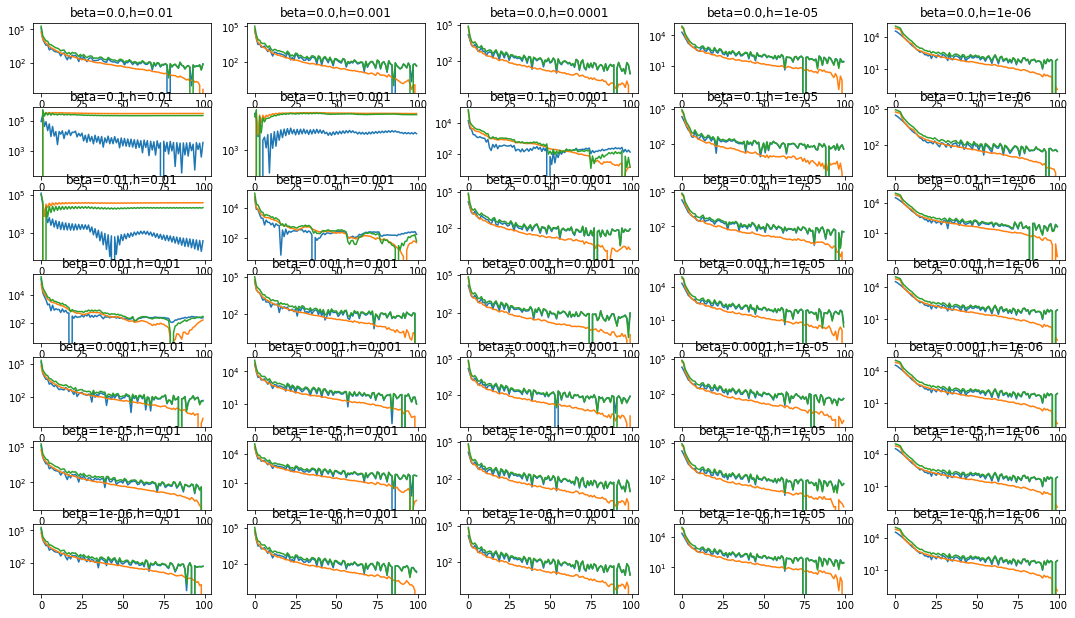

In [45]:
print('Blue - dual values, yellow - primal values, green - duality gap')
print('Max_iter =', max_iter)
fig, ax = plt.subplots(nrows=len(beta_range), ncols=len(h_range))
fig.set_size_inches(18.5, 10.5)
for i, row in enumerate(ax):
    for j, col in enumerate(row):
        beta = beta_range[i]
        h = h_range[j]
        
        col.set_title(f'beta={beta},h={h}')
        col.set_yscale('log')
        col.plot(np.arange(len(dual_vals[(beta,h)])), dual_vals[(beta,h)] - np.min(dual_vals[(beta,h)]), label='dual')
        col.plot(np.arange(len(primal_vals[(beta,h)])), primal_vals[(beta,h)] - np.min(primal_vals[(beta,h)]), label='primal')
        col.plot(np.arange(len(results[(beta,h)]['duality_gap_history'])), 
                 results[(beta,h)]['duality_gap_history'] - np.min(results[(beta,h)]['duality_gap_history']), 
                 label='duality gap')

### Comparison with Frank-Wolfe algorithm

In [46]:
# model.mu = 0.25
max_iter = 100

print('Frank-Wolfe without stopping criteria')
solver_kwargs = {'max_iter': max_iter}
tic = time.time()
result = model.find_equilibrium(solver_name = 'fwa', solver_kwargs = solver_kwargs, verbose = False)
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))

print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['Free Flow Time']))
print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['Capacity']) - 1, end = '\n\n')

# with open('anaheim_result_' + 'fwa' + '_max_iter_' + str(max_iter) + 
#           '_Beckman.pickle', 'wb') as f:
#     pickle.dump(result, f)

Frank-Wolfe without stopping criteria


/home/user/frank_wolfe_algorithm.py:5: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "frank_wolfe_algorithm" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at /home/user/frank_wolfe_algorithm.py (9)

File "frank_wolfe_algorithm.py", line 9:
def frank_wolfe_algorithm(phi_big_oracle, primal_dual_oracle,
    <source elided>
                                         eps = 1e-5, eps_abs = None, verbose = False):
    iter_step = 5
    ^

  @jit
/home/user/frank_wolfe_algorithm.py:5: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "frank_wolfe_algorithm" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "frank_wolfe_algorithm.py", line 19:
def frank_wolfe_algorithm(phi_big_oracle, primal_dual_oracle,
    <source elided>
    
    for counter in range(1, max_iter):
    ^

  @jit
/usr/lib/python3

L_init =  1.0


/home/user/frank_wolfe_algorithm.py:5: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "frank_wolfe_algorithm" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at /home/user/frank_wolfe_algorithm.py (19)

File "frank_wolfe_algorithm.py", line 19:
def frank_wolfe_algorithm(phi_big_oracle, primal_dual_oracle,
    <source elided>
    
    for counter in range(1, max_iter):
    ^

  @jit
/usr/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "frank_wolfe_algorithm" was compiled in object mode without forceobj=True.

File "frank_wolfe_algorithm.py", line 19:
def frank_wolfe_algorithm(phi_big_oracle, primal_dual_oracle,
    <source elided>
    
    for counter in range(1, max_iter):
    ^

  state.func_ir.loc))
/usr/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode co

Elapsed time: 9 sec
Time ratio = 2.9107237337628975
Flow excess = 0.889194444444444



In [50]:
flows['fwa']=result['flows']
times['fwa']=result['times']
iter_nums['fwa']=result['iter_num']
primal_vals['fwa']=result['primal_func_history']

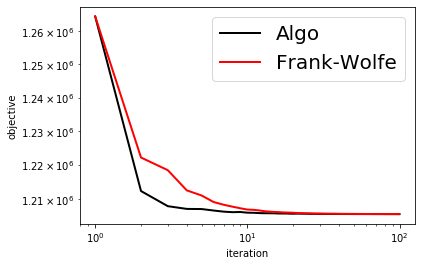

In [71]:
plt.rc('text')#, usetex = False)

plt.loglog(np.arange(1, len(primal_vals[(0.0001,0.0001)]) + 1), primal_vals[(0.0001,0.0001)], 'black', label = 'Algo', linewidth=2)#, marker='^')
plt.loglog(np.arange(1, len(primal_vals['fwa']) + 1), primal_vals['fwa'], 'red', label = 'Frank-Wolfe', linewidth=2)#, marker='o')

plt.xlabel('iteration')
plt.ylabel('objective')
plt.legend()
legend = plt.legend(loc=0,fontsize=20)
text = legend.get_texts()[1]
props = text.get_font_properties().copy()
text.set_fontproperties(props)
text.set_size(20)

#plt.savefig('anaheim_primal__vs_iters_fwa_ustf_correct_eps_absolute_100_loglog.png', dpi = 300)
# plt.show()

In [7]:
model.mu = 0.25
max_iter = 10000

print('Frank-Wolfe without stopping criteria')
solver_kwargs = {'max_iter': max_iter}
tic = time.time()
result = model.find_equilibrium(solver_name = 'fwa', solver_kwargs = solver_kwargs, verbose = False)
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))

print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['Free Flow Time']))
print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['Capacity']) - 1, end = '\n\n')

with open('anaheim_result_' + 'fwa' + '_max_iter_' + str(max_iter) + 
          '_Beckman.pickle', 'wb') as f:
    pickle.dump(result, f)

Frank-Wolfe without stopping criteria
L_init =  1.0
Elapsed time: 1185 sec
Time ratio = 2.9107237337629295
Flow excess = 0.8891944444444517



### Conclusion